# Reconstruction test  
Alexxela was trained for 750 epochs. Latent space - 64 dim  
Batch-wise test

In [1]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam

from absl import app


# logging
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import shutil
from glob import glob

Using TensorFlow backend.
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

## Load models

In [2]:
encoder = load_model("/home/aogorodnikov/alexxela_750e/encoder.h5")
decoder = load_model("/home/aogorodnikov/alexxela_750e/decoder.h5")
discriminator = load_model("/home/aogorodnikov/alexxela_750e/discriminator.h5")
generator = load_model("/home/aogorodnikov/alexxela_750e/generator.h5")








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## Notes  
We need to set basic parameters for input data, like dimensions, number of filters (3 for RGB)  
Also we compile the models

In [3]:
input_dim = (224, 224, 3)
latent_dim=64

# compile imported models into assembled autoencoder
autoencoder_input = Input(shape=input_dim)
autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])
discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

## Notes  
We create a function that takes a single class (cellular phenotype) and test reconstruction loss for autoencoder and discriminator

In [4]:
def anomaly_score(cell_pheno):
    [shutil.rmtree(x) for x in glob("/home/aogorodnikov/test/*")]
    input_dir = os.path.join("/home/aogorodnikov/classes_rgb_corrected/", cell_pheno)
    shutil.copytree(input_dir, os.path.join("/home/aogorodnikov/test/", cell_pheno))
    img_wd = "/home/aogorodnikov/test"
    batch = 56
    input_dim = (224, 224, 3)
    data_loader = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_data = data_loader.flow_from_directory(
        img_wd,
        target_size=(input_dim[0], input_dim[0]),
        batch_size=batch,
        class_mode='input')
    
    batch_index = 0
    discriminator_batch_losses = []
    while batch_index <= train_data.batch_index:
        data = train_data.next()
        data_list = data[0]
        data_size = len(data_list)

        fake_latent = encoder.predict(data_list)
        discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))
        discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
        discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)

            
        batch_index = batch_index + 1
        discriminator_batch_losses.append(discriminator_history[0])
    
    
    
    
    ae_res = autoencoder.evaluate_generator(train_data, steps=len(train_data))[0]
    adv_res = np.mean(discriminator_batch_losses)
    
    print('Class: {}\nae_loss: {}\nadv_loss: {}'.format(cell_pheno, ae_res, adv_res))
    return [ae_res, adv_res]
    
        

## Notes  
We create a list of thise class directories and deploy the function above in list comprehension logic

In [5]:
dirs = [x for x in os.listdir("/home/aogorodnikov/classes_rgb_corrected/") if os.path.isdir(os.path.join("/home/aogorodnikov/classes_rgb_corrected/", x))]
results = [[x, anomaly_score(cell_pheno=x)] for x in dirs]

Found 1365 images belonging to 1 classes.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


42/42 [==============================] - 0s 282us/step
Class: confluent
ae_loss: 0.0035562902020338256
adv_loss: 0.012116838277496362
Found 313 images belonging to 1 classes.
66/66 [==============================] - 0s 261us/step
Class: cytokinesis
ae_loss: 0.003958720126198218
adv_loss: 0.02321871414111638
Found 5616 images belonging to 1 classes.
32/32 [==============================] - 0s 185us/step
Class: negative
ae_loss: 0.0027060560670487603
adv_loss: 0.021974207248372662
Found 310 images belonging to 1 classes.
60/60 [==============================] - 0s 205us/step
Class: nuclear_mess
ae_loss: 0.004275943654318971
adv_loss: 0.022376594801642655
Found 4287 images belonging to 1 classes.
62/62 [==============================] - 0s 209us/step
Class: large_nuclei
ae_loss: 0.0033585187962314788
adv_loss: 0.01719844515973676
Found 1077 images belonging to 1 classes.
26/26 [==============================] - 0s 213us/step
Class: other
ae_loss: 0.002584644241782533
adv_loss: 0.008850360

## Notes  
Printed results show adversarial and autoencoder losses for each class

In [6]:
results

[['confluent', [0.0035562902020338256, 0.012116838277496362]],
 ['cytokinesis', [0.003958720126198218, 0.02321871414111638]],
 ['negative', [0.0027060560670487603, 0.021974207248372662]],
 ['nuclear_mess', [0.004275943654318971, 0.022376594801642655]],
 ['large_nuclei', [0.0033585187962314788, 0.01719844515973676]],
 ['other', [0.002584644241782533, 0.00885036019213398]],
 ['micronuclei', [0.0038478193549678647, 0.01796169673315336]],
 ['spindle', [0.0027094209490686047, 0.013994227266287051]],
 ['normal', [0.0021285811642963964, 0.034755701223616764]],
 ['Y', [0.0034916062317224164, 0.010076399308142883]],
 ['binucleated', [0.003170449082972482, 0.015728229484531245]],
 ['new_neg', [0.002796874347242144, 0.02163683374674769]],
 ['polarity', [0.003166216053068638, 0.020163340150611476]],
 ['croissant', [0.0031985888454778054, 0.016050103488192274]]]

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageD

[(0, 1.8)]

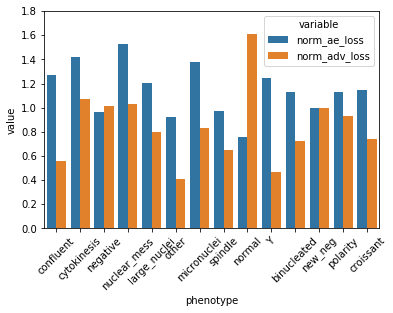

In [7]:
import pandas as pd
import seaborn as sns

res_dict = {x[0]: x[1] for x in results}
res_df = pd.DataFrame(res_dict, index=["ae_loss", "adv_loss"]).transpose()
res_df['phenotype'] = res_df.index
res_df['norm_ae_loss'] = res_df.ae_loss / float(res_df.loc[res_df.phenotype=='new_neg','ae_loss'])
res_df['norm_adv_loss'] = res_df.adv_loss / float(res_df.loc[res_df.phenotype=='new_neg','adv_loss'])
res_df.drop(['ae_loss', 'adv_loss'], axis=1, inplace=True)
res_melt = pd.melt(res_df,id_vars="phenotype")

# plotting
ax = sns.barplot(x='phenotype', y='value', hue='variable', data=res_melt)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(ylim=(0, 1.8))

### Import and export  
Export as tables to merge with other data

In [8]:
# arrange cols
res_ae = res_df.drop("norm_adv_loss", axis=1).rename(columns = {'norm_ae_loss':'alexxela_64d'})
res_adv = res_df.drop("norm_ae_loss", axis=1).rename(columns = {'norm_adv_loss':'alexxela_64d'})

In [9]:
# import 
ae_losses = pd.read_csv("/home/aogorodnikov/image_sudoku/ae_losses.tsv", sep='\t')
adv_losses = pd.read_csv("/home/aogorodnikov/image_sudoku/adv_losses.tsv", sep='\t')

res_ae = res_ae.merge(ae_losses, on='phenotype')
res_adv = res_adv.merge(adv_losses, on='phenotype')

In [14]:
res_ae.to_csv("/home/aogorodnikov/image_sudoku/ae_losses.tsv", sep='\t', index=False)
res_adv.to_csv("/home/aogorodnikov/image_sudoku/adv_losses.tsv", sep='\t', index=False)

In [15]:
rec_loss = [x[1][0] for x in results]
adv_loss = [x[1][1] for x in results]

In [16]:
np.percentile(rec_loss, 60)

0.003326532806080744

In [17]:
np.percentile(adv_loss, 60)

0.019723011467119852

# Conclusions  
1. Way better performance with 2D latent space

In [18]:
img_wd = "/home/aogorodnikov/test/"
batch = 56
input_dim = (224, 224, 3)
latent_dim=64



In [19]:
# LOAD DATA
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')

Found 5319 images belonging to 1 classes.


In [20]:
data = train_data.next()
data_list = data[0]
fake_latent = encoder.predict(data_list)

In [21]:
def draw(samples):
    fig = plt.figure(figsize=(5 * len(samples), 5))
    gs = gridspec.GridSpec(1, len(samples))
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).astype("int"), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)

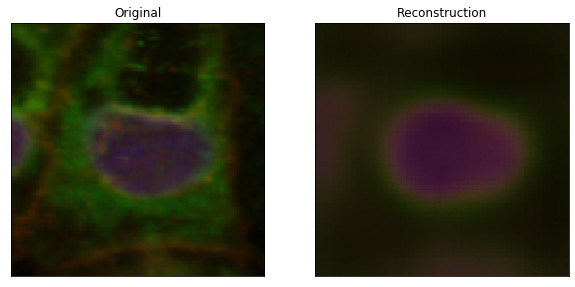

In [22]:
choice = np.random.choice(np.arange(32))
#choice = 0
original = data_list[choice]

original_1 = np.expand_dims(original, axis=0)

latent = encoder.predict(original_1)

reconstruction = decoder.predict(latent)

draw([{"title": "Original", "image": original}, {"title": "Reconstruction", "image": reconstruction[0]}])

